# Example of Loading and pre-processing data for causality project

#### Using Iris for NetCDF data load and processing

### __Calculate boreal summer precipitation (JJA) averages for Borneo DROUGHT__

#### Imports

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.cm as mpl_cm

import numpy as np

import os

import iris

import iris.quickplot as qplt
import iris.coord_categorisation as coord_cat


#### Set data path

In [2]:
DATA_PATH = 'D:/UoE/Projects/Thesis_Formulation_Report/Script/from_Panzure/ncep/'

#### Load monthly precipitation data into an Iris cube

In [3]:
precip_path = os.path.join(DATA_PATH, 'prate.sfc.mon.mean.nc')
precip = iris.load_cube(precip_path, 'Monthly Mean of Precipitation Rate')
precip.coord('latitude').guess_bounds()
precip.coord('longitude').guess_bounds()


C:\Users\user\Anaconda3\lib\site-packages\iris\fileformats\_pyke_rules\compiled_krb\fc_rules_cf_fc.py:2206: UserWarning: Ignoring netCDF variable 'prate' invalid units 'Kg/m^2/s'
  warnings.warn(msg)


#### Plot some data

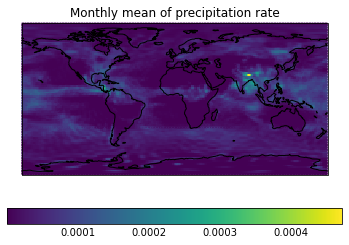

In [4]:
qplt.pcolormesh(precip[6]) # plot the first time in the cube
plt.gca().coastlines()

#### Create seasonal means

In [4]:
coord_cat.add_season(precip, 'time', name='clim_season')
coord_cat.add_season_year(precip, 'time', name='season_year')

In [5]:
print(precip)

Monthly Mean of Precipitation Rate / (unknown) (time: 867; latitude: 94; longitude: 192)
     Dimension coordinates:
          time                                      x              -              -
          latitude                                  -              x              -
          longitude                                 -              -              x
     Auxiliary coordinates:
          clim_season                               x              -              -
          season_year                               x              -              -
     Attributes:
          Conventions: COARDS
          NCO: 20121013
          References: http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanalysis.derived...
          actual_range: [-2.3283064e-10  5.8903999e-04]
          dataset: NCEP Reanalysis Derived Products
          dataset_title: NCEP-NCAR Reanalysis 1
          description: Data is from NMC initialized reanalysis
(4x/day).  It consists of T42 ...
          histo

In [6]:
# Aggregate by clim season and season year
annual_seasonal_mean = precip.aggregated_by(
    ['clim_season', 'season_year'],
    iris.analysis.MEAN)

#### Check this worked

In [8]:
for season, year in zip(
    annual_seasonal_mean.coord('clim_season')[:10].points,
    annual_seasonal_mean.coord('season_year')[:10].points):
    print(season + ' ' + str(year))

djf 1948
mam 1948
jja 1948
son 1948
djf 1949
mam 1949
jja 1949
son 1949
djf 1950
mam 1950


#### Extract Borneo region (as specified by https://daac.ornl.gov/CMS/guides/CMS_LiDAR_Indonesia.html) 

In [7]:
# Create a constraint for the latitude and Longitude extents

s_Borneo_lat = iris.Constraint(latitude=lambda v: v > -4.757 and v <= 3.211 )
s_Borneo_lon = iris.Constraint(longitude=lambda v: v > 107.815 and v <= 117.987 )

s_Borneo =  annual_seasonal_mean.extract(s_Borneo_lat & s_Borneo_lon) 

#### Plot some data to check

Monthly Mean of Precipitation Rate / (unknown) (time: 290; latitude: 4; longitude: 5)
     Dimension coordinates:
          time                                      x              -             -
          latitude                                  -              x             -
          longitude                                 -              -             x
     Auxiliary coordinates:
          clim_season                               x              -             -
          season_year                               x              -             -
     Attributes:
          Conventions: COARDS
          NCO: 20121013
          References: http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanalysis.derived...
          actual_range: [-2.3283064e-10  5.8903999e-04]
          dataset: NCEP Reanalysis Derived Products
          dataset_title: NCEP-NCAR Reanalysis 1
          description: Data is from NMC initialized reanalysis
(4x/day).  It consists of T42 ...
          history: Mon 

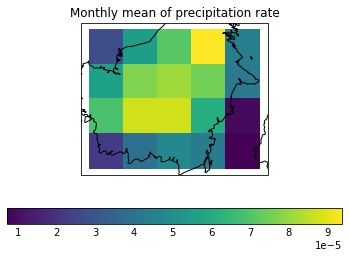

In [11]:
print(s_Borneo)
qplt.pcolormesh(s_Borneo[138]) # plot the rainfall in jja 1982 (strong El Nino year) in the cube
plt.gca().coastlines()

#### Save to new NetCDF files

In [25]:
iris.save(s_Borneo, './Borneo_precip.nc')

#### Create area-averaged time series for Borneo

In [12]:
# Create area-weights array
grid_area_weights = iris.analysis.cartography.area_weights(s_Borneo)

# Perform the area-weighted mean using the computed grid-box areas.
s_Borneo_mean = s_Borneo.collapsed(['latitude', 'longitude'],
                                iris.analysis.MEAN,
                                weights=grid_area_weights)

C:\Users\user\Anaconda3\lib\site-packages\iris\analysis\cartography.py:394: UserWarning: Using DEFAULT_SPHERICAL_EARTH_RADIUS.
  warnings.warn("Using DEFAULT_SPHERICAL_EARTH_RADIUS.")


#### Extract JJA data and restrict to 1950-2019

In [13]:
jja_constraint = iris.Constraint(clim_season='jja')
year_constraint = iris.Constraint(season_year=lambda v: v > 1949 and v <= 2019 )

s_Borneo_jja = s_Borneo_mean.extract(jja_constraint & year_constraint)
print(s_Borneo_jja)

Monthly Mean of Precipitation Rate / (unknown) (time: 70)
     Dimension coordinates:
          time                                      x
     Auxiliary coordinates:
          clim_season                               x
          season_year                               x
     Scalar coordinates:
          latitude: 0.0 degrees, bound=(-3.80947, 3.80947) degrees
          longitude: 114.375 degrees, bound=(109.6875, 119.0625) degrees
     Attributes:
          Conventions: COARDS
          NCO: 20121013
          References: http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanalysis.derived...
          actual_range: [-2.3283064e-10  5.8903999e-04]
          dataset: NCEP Reanalysis Derived Products
          dataset_title: NCEP-NCAR Reanalysis 1
          description: Data is from NMC initialized reanalysis
(4x/day).  It consists of T42 ...
          history: Mon Jul  5 23:55:54 1999: ncrcat prate.mon.mean.nc /Datasets/ncep.reanalysis.derived/surface_gauss/prate.mon.mean.nc...


Text(0.5, 1.0, 'Borneo JJA Precip')

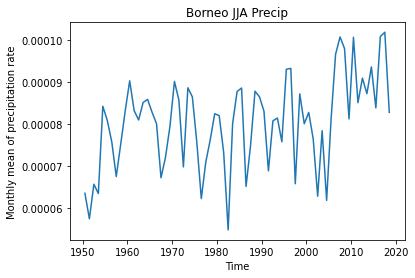

In [16]:
qplt.plot(s_Borneo_jja[-71:-1])
plt.title('Borneo JJA Precip')

In [33]:
iris.save(s_Borneo_jja, './Borneo_precip_mean.nc')

In [20]:
from scipy import signal

pBorneo_trend = s_Borneo_jja - signal.detrend(s_Borneo_jja.data)
pBorneo_det = s_Borneo_jja  - pBorneo_trend
pBorneo_std = (pBorneo_det - np.mean(pBorneo_det.data))/np.std(pBorneo_det.data)

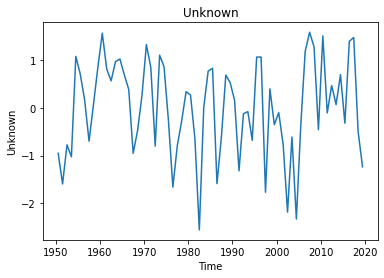

In [31]:
qplt.plot(pBorneo_std[-71:])


In [26]:
print(pBorneo_std.data)

[-0.9533537641685524 -1.5960023239481926 -0.7766184235894185
 -1.0256407734883703 1.0781250609405566 0.7101491337293683
 0.1654575562634506 -0.7004447100810071 0.06683537957032952
 0.8506099373660476 1.5644538261139929 0.8151788870601352
 0.5660331994390891 0.9688470704421136 1.0229315554728684
 0.6874673559679919 0.38489710754922163 -0.9536814294019345
 -0.4782110849330343 0.2578623487988647 1.3257727630550937
 0.8479978771716684 -0.8018600959835891 1.1039125057773878
 0.8614477293800399 -0.26885478517639144 -1.6628572488939832
 -0.7984525145452326 -0.2739270786821105 0.33854730613111966
 0.2682526950619149 -0.6504057274858 -2.5600180269293125
 0.006805244669981722 0.768506859767856 0.8300521525720779
 -1.5904585207615853 -0.6236929269593461 0.6855042001057269
 0.5260313120320572 0.15527756612657048 -1.32122441556201
 -0.12578781343577206 -0.07968601704969416 -0.680713652892611
 1.063093000159436 1.0634671560412843 -1.76997978037208 0.3971541899759596
 -0.35305790035493634 -0.09983973

#### Load long term mean

In [15]:
precip_mean = iris.load(DATA_PATH + 'prate.sfc.mon.ltm.nc')
print (precip_mean[0])

count of non-missing values used in mean / (unknown) (time: 12; latitude: 94; longitude: 192)
     Dimension coordinates:
          time                                            x             -              -
          latitude                                        -             x              -
          longitude                                       -             -              x
     Attributes:
          Conventions: COARDS
          References: http://www.psl.noaa.gov/data/gridded/data.ncep.reanalysis.derived.html
          dataset_title: NCEP-NCAR Reanalysis 1
          description: Data is from NMC initialized reanalysis
(4x/day).  It consists of T42 ...
          history: Created 2011/07/12 by doMonthLTM
Converted to chunked, deflated non-packed...
          not_missing_threshold_percent: minimum 3% values input to have non-missing output value
          platform: Model
          title: 4x daily NMC reanalysis


C:\Users\user\Anaconda3\lib\site-packages\iris\fileformats\_pyke_rules\compiled_krb\fc_rules_cf_fc.py:2206: UserWarning: Ignoring netCDF variable 'prate' invalid units 'Kg/m^2/s'
  warnings.warn(msg)


In [16]:
precip_mean_path = os.path.join(DATA_PATH, 'prate.sfc.mon.ltm.nc')
precip_mean = iris.load_cube(precip_mean_path, 'Monthly Long Term Mean of Precipitation Rate')
precip_mean.coord('latitude').guess_bounds()
precip_mean.coord('longitude').guess_bounds()

C:\Users\user\Anaconda3\lib\site-packages\iris\fileformats\_pyke_rules\compiled_krb\fc_rules_cf_fc.py:2206: UserWarning: Ignoring netCDF variable 'prate' invalid units 'Kg/m^2/s'
  warnings.warn(msg)


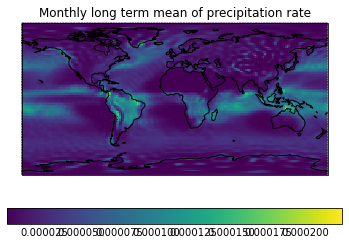

In [12]:
qplt.pcolormesh(precip_mean[0]) # plot the first time in the cube
plt.gca().coastlines()

In [17]:
coord_cat.add_season(precip_mean, 'time', name='clim_season')
coord_cat.add_season_year(precip_mean, 'time', name='season_year')

In [37]:
print(precip_mean)

Monthly Long Term Mean of Precipitation Rate / (unknown) (time: 12; latitude: 94; longitude: 192)
     Dimension coordinates:
          time                                                x             -              -
          latitude                                            -             x              -
          longitude                                           -             -              x
     Auxiliary coordinates:
          clim_season                                         x             -              -
          season_year                                         x             -              -
     Attributes:
          Conventions: COARDS
          References: http://www.psl.noaa.gov/data/gridded/data.ncep.reanalysis.derived.html
          actual_range: [9.320987e-08 2.932220e-04]
          dataset: NCEP Reanalysis Derived Products
          dataset_title: NCEP-NCAR Reanalysis 1
          description: Data is from NMC initialized reanalysis
(4x/day).  It consists of 

In [18]:
annual_seasonal_ltm = precip_mean.aggregated_by(
    ['clim_season', 'season_year'],
    iris.analysis.MEAN)

In [19]:
for season, year in zip(
    annual_seasonal_ltm.coord('clim_season')[:10].points,
    annual_seasonal_ltm.coord('season_year')[:10].points):
    print(season + ' ' + str(year))

djf 1
mam 1
jja 1
son 1
djf 2


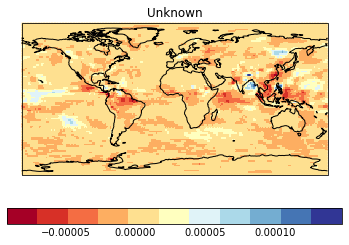

In [20]:
qplt.pcolormesh(annual_seasonal_mean[2] - annual_seasonal_ltm[2], cmap=mpl_cm.get_cmap('brewer_RdYlBu_11')) 
plt.gca().coastlines()

#### Extract Borneo region for anomaly plots

In [20]:
s_Borneo_ltm = annual_seasonal_ltm.extract(s_Borneo_lat & s_Borneo_lon) 

In [21]:
jja_constraint = iris.Constraint(clim_season='jja')
year_constraint = iris.Constraint(season_year=lambda v: v > 1949 and v <= 2019 )

s_Borneo_jja = s_Borneo.extract(jja_constraint & year_constraint)
s_Borneo_ltm_jja = s_Borneo_ltm.extract(jja_constraint)

print (s_Borneo_jja)
print (s_Borneo_ltm_jja)

Monthly Mean of Precipitation Rate / (unknown) (time: 70; latitude: 4; longitude: 5)
     Dimension coordinates:
          time                                      x             -             -
          latitude                                  -             x             -
          longitude                                 -             -             x
     Auxiliary coordinates:
          clim_season                               x             -             -
          season_year                               x             -             -
     Attributes:
          Conventions: COARDS
          NCO: 20121013
          References: http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanalysis.derived...
          actual_range: [-2.3283064e-10  5.8903999e-04]
          dataset: NCEP Reanalysis Derived Products
          dataset_title: NCEP-NCAR Reanalysis 1
          description: Data is from NMC initialized reanalysis
(4x/day).  It consists of T42 ...
          history: Mon Jul  5

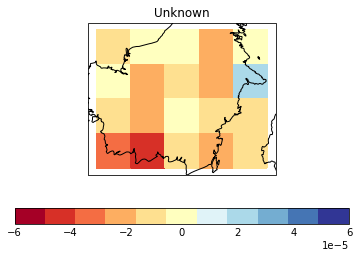

In [35]:
qplt.pcolormesh(s_Borneo_jja[26] - s_Borneo_ltm_jja[0], cmap=mpl_cm.get_cmap('brewer_RdYlBu_11'), vmin=-0.00006, vmax=0.00006) # plot the rainfall of dry years in the cube
plt.gca().coastlines()